In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *
from torchvision.transforms import ToTensor, ToPILImage, Pad, Compose
from torchvision.utils import make_grid
from core.utils.CNN_scorers import resize_and_pad_tsr


In [2]:
# set variabels
pd_key="expriment_meta_data_df"
proc_data_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set"
rawdata_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set\unit_inflation_small_set_081723"
save_root = os.path.join(proc_data_root, "results")
os.makedirs(save_root, exist_ok=True)

In [3]:
# metadata loading
''''
data_path = os.path.join(proc_data_root, "meta_data_seprated") 
meta_data_df = pd.DataFrame()
for file in os.listdir(data_path):
    if file.endswith(".h5"):
        metadata_df = pd.read_hdf(os.path.join(data_path, file), key=pd_key)
        # each file is saved with the name of the data folder with a suffix of a random number at the end of the name taht
        # splited with "_" so we want to extract the data folder name from the file name and add it as a column to the metadata data frame
        folder_name = file.split("_")[1]
        for si in file.split("_")[2:-1]:
            folder_name = folder_name +("_"+si)

        metadata_df["data_root"] = os.path.join(rawdata_root, folder_name)
        # print humner of repited index in the metadata data frame
        meta_data_df = pd.concat([meta_data_df, metadata_df], axis=0)
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
os.makedirs(concated_df_path, exist_ok=True)
meta_data_df.to_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)
'''
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
metadata_df_cosine = pd.read_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)
metadata_df_cosine.loc[metadata_df_cosine['modif_unit_id'].isnull(), 'exp_stage'] = 'reconstruction'


In [4]:
metadata_df_cosine.columns

Index(['output_type', 'trget_imge_name', 'similarity_metric', 'pop_size',
       'pop_resampling_id', 'gan_name', 'layer_name', 'layer_short',
       'net_name', 'img_size', 'pading_size', 'input_size', 'score',
       'pop_unit_idx', 'sub_pop_type', 'gen_rerun_id', 'modif_unit_idx',
       'modif_unit_id', 'exp_stage', 'data_root'],
      dtype='object')

In [6]:
# first thing, first. let look all optimiztion trajectory 

image_name_list = metadata_df_cosine["trget_imge_name"].unique()
layer_short= "conv5"
similarity_metric_list = ["cosine", "MSE"]
smpling_types = {"most", 'random'}
pop_size = 128
gen_rerun_id_max = metadata_df_cosine["gen_rerun_id"].max()
pop_resampling_max = metadata_df_cosine["pop_resampling_id"].max()

target_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"
pop_resampling_id = 0
save_path_root = os.path.join(save_root, f"inflation_tragectory_popsize{pop_size}")
for smpling_type in smpling_types:   
    save_path_image_root = os.path.join(save_path_root, smpling_type)
    for similarity_metric in similarity_metric_list:
        save_path_sim_metric = os.path.join(save_path_image_root, similarity_metric)
        for image_name in image_name_list:
            save_path_img_tag = os.path.join(save_path_sim_metric, image_name)
            for gen_rerun_id in range(gen_rerun_id_max+1):
                save_path_gen_rerun = os.path.join(save_path_img_tag, f"gen_rerun_id_{gen_rerun_id}")
                save_path = save_path_gen_rerun
                os.makedirs(save_path, exist_ok=True)

                target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=target_type, pop_size=pop_size,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                
                recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                
                pop_act_evol = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')    

                fig, ax = plt.subplots(figsize=(5, 5))
                ax.imshow(ToPILImage()(target_image))
                ax.set_title(f"target image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure 
                plt.savefig(os.path.join(save_path, f"{image_name}_{target_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.jpg"), bbox_inches="tight", pad_inches=0)
                plt.close()
                
                fig, ax = plt.subplots(figsize=(5, 5))
                ax.imshow(ToPILImage()(recontruction_image))
                ax.set_title(f"recontrted image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure 
                plt.savefig(os.path.join(save_path, f"{image_name}_{gen_image_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.jpg"), bbox_inches="tight", pad_inches=0)
                plt.close()

                fig, ax = plt.subplots(figsize=(5, 5))
                ax.imshow(ToPILImage()(pop_act_evol))
                ax.set_title(f"population activity evolution for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"{image_name}_{pop_act_evol_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.jpg"), bbox_inches="tight", pad_inches=0)
                plt.close()

                for ni in range(pop_size):
                    file_name=f"{image_name}_{inflation_tragectory_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}_{ni}"
                    inflation_tragectory = coppy_image(metadata_df_cosine, save_path, new_file_name=file_name, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=inflation_tragectory_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation', modif_unit_idx=ni)

In [4]:
# clustering the units based on the similarity of the activity pattern of the units in the last step, and print samples
from core.utils.CNN_scorers import resize_and_pad_tsr
from core.utils.GAN_utils import upconvGAN
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_name_list = metadata_df_cosine["trget_imge_name"].unique()
# perpare the the image_name_list
image_name_list = [image_name_list[1], image_name_list[0], image_name_list[2]]
layer_short= "conv5"
similarity_metric_list = ["MSE", "cosine"]
smpling_types = {"most", 'random'}
pop_size = 128
gen_rerun_id_max = metadata_df_cosine["gen_rerun_id"].max()
pop_resampling_max = metadata_df_cosine["pop_resampling_id"].max()

target_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"

pro_image_type = "best_gen_imgs"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"

inflation_evol_data_type = "generation_data"

# set foint size
plt.rcParams.update({'font.size': 21})

# Load or create your matrix
metric_list = ['euclidean', 'cosine']  # Example metric in ['euclidean', 'correlation', 'cosine']

import numpy as np
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

RF_treshold = 2
pop_resampling_id = 0
num_of_sample_to_print = 16
save_path_root = os.path.join(save_root, f"inflation_profile_{pop_size}_v3")

# load rsetive filed mask
rf_obj = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))

# setup the  GAN
gan_name = 'fc6'
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
Ngens = 100
num_gen = 100
# Define the frames per second (fps) for the output video
fps = 5
# Define the dimensions of the frames (width, height)
frame_width = 480*2*4
frame_height = 480*4

# Define the output video filename
output_filename_v1 = 'inflation_clip_16_sample.mp4'
output_filename_v2 = 'inflation_clip_cluster_representive.mp4'
for smpling_type in smpling_types:   
    save_path_image_root = os.path.join(save_path_root, smpling_type)
    for si, similarity_metric in enumerate(similarity_metric_list):
        metric = metric_list[si]
        save_path_sim_metric = os.path.join(save_path_image_root, similarity_metric)
        for image_name in image_name_list:
            save_path_img_tag = os.path.join(save_path_sim_metric, image_name)
            for gen_rerun_id in range(gen_rerun_id_max+1):
                save_path_gen_rerun = os.path.join(save_path_img_tag, f"gen_rerun_id_{gen_rerun_id}")
                save_path = save_path_gen_rerun
                os.makedirs(save_path, exist_ok=True)
                os.makedirs(os.path.join(save_path, 'frames_16_rand_sample'), exist_ok=True)   
                os.makedirs(os.path.join(save_path, 'frames_cluster_rep'), exist_ok=True) 
                # Create the VideoWriter object
                # Create a VideoWriter object to write the video
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec for the output format
                out1 = cv2.VideoWriter(os.path.join(save_path, output_filename_v1), fourcc, fps, (frame_width, frame_height))
                out2 = cv2.VideoWriter(os.path.join(save_path, output_filename_v2), fourcc, fps, (frame_width, frame_height))

                actmat_mtx = np.zeros((pop_size, pop_size))
                sample_batch_size = 100
                unit_inflation_codes = list()
                unit_inflation_score = np.zeros((pop_size, num_gen))
                prototypes_list = list()
                prototypes_score = np.zeros((pop_size, 1))
                prototypes_unit_id = np.zeros((pop_size, 1))
                for ni in range(pop_size):
                    inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                            output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                            similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                            pop_resampling_id=pop_resampling_id, exp_stage = 'inflation', modif_unit_idx=ni)
                    actmat_all = inflation_evol_data['actmat_all']
                    generations = inflation_evol_data['generations']
                    scores_all = inflation_evol_data['scores_all']
                    best_code_all = inflation_evol_data['best_codes']
                    unit_inflation_codes.append(best_code_all)
                    for gi in range(num_gen):
                        scores_gen = scores_all[generations == gi]
                        max_score_index = scores_gen.argmax()
                        unit_inflation_score[ni, gi] = scores_gen[max_score_index]
                    # get cell prototypes
                    unit_prtoptype = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                    prototypes_score[ni] = column_inquary('score', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                    prototypes_list.append(unit_prtoptype)

                    best_actmat = actmat_all[scores_all.argmax(), :]
                    actmat_mtx[ni, :] = best_actmat

                # Calculate the pairwise distance matrix using correlation distance
                distance_matrix = pairwise_distances(actmat_mtx, metric=metric)
                # Perform hierarchical clustering
                linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

                # Get the cluster labels using fcluster
                num_clusters = 9  # Number of clusters
                clusters = hierarchy.fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

                # Plot the dendrogram
                plt.figure(figsize=(8, 3))
                dendrogram = hierarchy.dendrogram(linkage_matrix, labels=range(actmat_mtx.shape[0]), color_threshold=0, above_threshold_color='grey')
                plt.title("Dendrogram")
                plt.xlabel("Observations")
                plt.ylabel("Distance")
                plt.xticks([])
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"Dendrogram_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()

                # Get the order of columns after clustering
                sorted_indices = dendrogram['leaves']
                sorted_matrix = actmat_mtx[sorted_indices, :]
                clusters_sorted = clusters[sorted_indices]

                # Calculate the similarity matrix (e.g., correlation) for the sorted columns
                #sorted_similarity_matrix = np.corrcoef(sorted_matrix, rowvar=False)
                sorted_disimilarity_matrix = pairwise_distances(sorted_matrix, metric=metric)
                if metric in ['correlation', 'cosine']:
                    sorted_disimilarity_matrix = 1 - sorted_disimilarity_matrix
                elif metric == 'euclidean':
                    sorted_disimilarity_matrix =  sorted_disimilarity_matrix

                
                # sort the distance_matrix and get sort indacis
                sort_indacis = np.argsort(distance_matrix[distance_matrix.var(axis=0).argmax()])

                # get the 16 samples uniformaly distributed in the range of 0 to len(sort_indacis) and incluuide the first sample
                saples_idx = np.linspace(0, len(sort_indacis)-1, num_of_sample_to_print, dtype=int)
                sample_indacis = sort_indacis[saples_idx]

                # get idx of one random sample for each cluster
                clrester_rep_sample_idx = [np.random.choice(np.where(clusters== i)[0]) for i in np.arange(1, max(clusters))]
                
                # Plot the sorted similarity matrix
                plt.figure(figsize=(8, 8))
                plt.imshow(sorted_disimilarity_matrix, cmap='viridis', interpolation='nearest')
                # Plot colored cluster lines on the similarity matrix
                for i in range(1, num_clusters):
                    cluster_indices = np.where(clusters_sorted == i)[0]
                    plt.axvline(x=cluster_indices[-1] + 0.5, color='r', linestyle='--', linewidth=2)
                    plt.axhline(y=cluster_indices[-1] + 0.5, color='r', linestyle='--', linewidth=2)
                cbar = plt.colorbar()
                cbar.set_label(f'{metric}',  labelpad=15, fontweight='bold', fontsize=27)   
                plt.title("Sorted disimilarity matrix")
                plt.xlabel("Sorted Observations")
                plt.ylabel("Sorted Observations")
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"disimilarity_matrix_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()
                ## plot reconstruction results

                target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=target_type, pop_size=pop_size,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                
                recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                
                pop_act_evol = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')    

                fig, ax = plt.subplots(figsize=(10, 10))
                ax.imshow(ToPILImage()(target_image))
                ax.set_title(f"target image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure 
                plt.savefig(os.path.join(save_path, f"{image_name}_{target_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()
                
                fig, ax = plt.subplots(figsize=(10, 10))
                ax.imshow(ToPILImage()(recontruction_image))
                ax.set_title(f"recontrted image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure 
                plt.savefig(os.path.join(save_path, f"{image_name}_{gen_image_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()

                fig, ax = plt.subplots(figsize=(10, 10))
                ax.imshow(ToPILImage()(pop_act_evol))
                ax.set_title(f"population activity evolution for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                ax.axis("off")
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"{image_name}_{pop_act_evol_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()
            
                ## make the video for random samples
                grid_size = 4
                for gi in np.linspace(0, Ngens-1, 100, dtype=int):
                    fig, ax = plt.subplots(grid_size,grid_size, figsize=(20, 10))
                    c = 0
                    for i in range(grid_size):
                        for j in range(grid_size):
                            ax[i,j].axis('off')
                            if c < len(sample_indacis):
                                ni = int(sample_indacis[c])
                                imgs_inf = G.visualize_batch_np(unit_inflation_codes[ni])
                                imgs_inf = resize_and_pad_tsr(imgs_inf, (147, 147), (40, 40))
                                imgs_inf = RF_mask_and_crop(imgs_inf, rf_obj, RF_treshold=2.5)

                                imgs_pro = prototypes_list[ni].unsqueeze(0)
                                imgs_pro = RF_mask_and_crop(imgs_pro, rf_obj, RF_treshold=2.5)
                                # concat tow tensors
                                img = torch.cat((imgs_inf[gi], imgs_pro[0]), dim=2)

                                title_str = f" {np.round(unit_inflation_score[ni, gi])} <- act. (S{c}) -> {np.round(prototypes_score[ni][0])}"
                                ax[i, j].imshow(ToPILImage()(img))
                                ax[i, j].set_title(title_str, fontsize=20)                                                           
                            c += 1
                    plt.tight_layout()
                    image_path = os.path.join(save_path, 'frames_16_rand_sample',f"gen_{gi}_inflation.png")

                    plt.savefig(image_path, dpi=300)
                    plt.close()
                    '''
                    canvas = FigureCanvas(fig)
                    canvas.draw()  # Render the figure

                    # Convert the rendered image to a NumPy array
                    width, height = fig.get_size_inches() * fig.get_dpi()
                    plt.close(fig)  
                    image_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
                    resized_frame = cv2.resize(image_array, (frame_width, frame_height))
                    '''               
                    # Read the image
                    frame = cv2.imread(image_path)                    
                    # Resize the frame to match the specified dimensions
                    frame = cv2.resize(frame, (frame_width, frame_height))
                    out1.write(frame)                     
                # Release the VideoWriter object
                out1.release()
                print("Video 1 creation complete.")

                ## make the video for random samples
                grid_size = 3
                for gi in np.linspace(0, Ngens-1, 100, dtype=int):
                    fig, ax = plt.subplots(grid_size,grid_size, figsize=(20, 10))
                    c = 0
                    for i in range(grid_size):
                        for j in range(grid_size):
                            ax[i,j].axis('off')
                            if c < len(clrester_rep_sample_idx):
                                ni = int(clrester_rep_sample_idx[c])
                                imgs_inf = G.visualize_batch_np(unit_inflation_codes[ni])
                                imgs_inf = resize_and_pad_tsr(imgs_inf, (147, 147), (40, 40))
                                imgs_inf = RF_mask_and_crop(imgs_inf, rf_obj, RF_treshold=2.5)

                                imgs_pro = prototypes_list[ni].unsqueeze(0)
                                imgs_pro = RF_mask_and_crop(imgs_pro, rf_obj, RF_treshold=2.5)
                                # concat tow tensors
                                img = torch.cat((imgs_inf[gi], imgs_pro[0]), dim=2)

                                title_str = f" {np.round(unit_inflation_score[ni, gi])} <- act. (C{c}) -> {np.round(prototypes_score[ni][0])}"
                                ax[i, j].imshow(ToPILImage()(img))
                                ax[i, j].set_title(title_str, fontsize=20)                                                           
                            c += 1
                    plt.tight_layout()
                    image_path = os.path.join(save_path, 'frames_cluster_rep', f"gen_{gi}_inflation.png")

                    plt.savefig(image_path, dpi=300)
                    plt.close()        
                    # Read the image
                    frame = cv2.imread(image_path)                    
                    # Resize the frame to match the specified dimensions
                    frame = cv2.resize(frame, (frame_width, frame_height))
                    out2.write(frame)                     
                # Release the VideoWriter object
                out2.release()
                print("Video 2 creation complete.")


                cv2.destroyAllWindows()
                # Display a message
                
                

C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_27748\1492969075.py:117: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


Video 1 creation complete.
Video 2 creation complete.


In [4]:
# clustering the units based on the similarity of the activity pattern of the units in the last step, and print samples
from core.utils.CNN_scorers import resize_and_pad_tsr
from core.utils.GAN_utils import upconvGAN
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


layer_short= "conv5"
pop_size = 128


target_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"

pro_image_type = "best_gen_imgs"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"

inflation_evol_data_type = "generation_data"

# set foint size
plt.rcParams.update({'font.size': 21})

# Load or create your matrix
metric_list = ['euclidean', 'cosine']  # Example metric in ['euclidean', 'correlation', 'cosine']

import numpy as np
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

RF_treshold = 2
pop_resampling_id = 0
num_of_sample_to_print = 16
save_path_root = os.path.join(save_root, f"inflation_profile_for_posetr_{pop_size}_v3")

# load rsetive filed mask
rf_obj = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))

# setup the  GAN
gan_name = 'fc6'
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
Ngens = 100
num_gen = 100
# Define params
smpling_type = 'random'
similarity_metric = 'MSE'
image_name = 'invar_1_flipped'
metric = 'euclidean'
gen_rerun_id = 0
save_path_image_root = os.path.join(save_path_root, smpling_type)
save_path_sim_metric = os.path.join(save_path_image_root, similarity_metric)
save_path_img_tag = os.path.join(save_path_sim_metric, image_name)            
save_path_gen_rerun = os.path.join(save_path_img_tag, f"gen_rerun_id_{gen_rerun_id}")
save_path = save_path_gen_rerun

os.makedirs(save_path, exist_ok=True)

actmat_mtx = np.zeros((pop_size, pop_size))
sample_batch_size = 100
unit_inflation_codes = list()
unit_inflation_score = np.zeros((pop_size, num_gen))
prototypes_list = list()
prototypes_score = np.zeros((pop_size, 1))
prototypes_unit_id = np.zeros((pop_size, 1))
for ni in range(pop_size):
    inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
            output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
            similarity_metric=similarity_metric, sub_pop_type=smpling_type,
            pop_resampling_id=pop_resampling_id, exp_stage = 'inflation', modif_unit_idx=ni)
    actmat_all = inflation_evol_data['actmat_all']
    generations = inflation_evol_data['generations']
    scores_all = inflation_evol_data['scores_all']
    best_code_all = inflation_evol_data['best_codes']
    unit_inflation_codes.append(best_code_all)
    for gi in range(num_gen):
        scores_gen = scores_all[generations == gi]
        max_score_index = scores_gen.argmax()
        unit_inflation_score[ni, gi] = scores_gen[max_score_index]
    # get cell prototypes
    unit_prtoptype = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
    prototypes_score[ni] = column_inquary('score', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
    prototypes_list.append(unit_prtoptype)

    best_actmat = actmat_all[scores_all.argmax(), :]
    actmat_mtx[ni, :] = best_actmat

# Calculate the pairwise distance matrix using correlation distance
distance_matrix = pairwise_distances(actmat_mtx, metric=metric)
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

# Get the cluster labels using fcluster
num_clusters = 9  # Number of clusters
clusters = hierarchy.fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Plot the dendrogram
plt.figure(figsize=(8, 3))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=range(actmat_mtx.shape[0]), color_threshold=0, above_threshold_color='grey')
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.xticks([])
plt.tight_layout()
# save the figure
plt.savefig(os.path.join(save_path, f"Dendrogram_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.close()

# get idx of one random sample for each cluster
clrester_rep_sample_idx = [np.random.choice(np.where(clusters== i)[0]) for i in np.arange(1, max(clusters))]

# Get the order of columns after clustering
sorted_indices = dendrogram['leaves']
sorted_matrix = actmat_mtx[sorted_indices, :]
clusters_sorted = clusters[sorted_indices]


# Calculate the similarity matrix (e.g., correlation) for the sorted columns
#sorted_similarity_matrix = np.corrcoef(sorted_matrix, rowvar=False)
sorted_disimilarity_matrix = pairwise_distances(sorted_matrix, metric=metric)
if metric in ['correlation', 'cosine']:
    sorted_disimilarity_matrix = 1 - sorted_disimilarity_matrix
elif metric == 'euclidean':
    sorted_disimilarity_matrix =  sorted_disimilarity_matrix


# Plot the sorted similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(sorted_disimilarity_matrix, cmap='viridis', interpolation='nearest')
# Plot colored cluster lines on the similarity matrix
for i in range(1, num_clusters):
    cluster_indices = np.where(clusters_sorted == i)[0]
    plt.axvline(x=cluster_indices[-1] + 0.5, color='r', linestyle='--', linewidth=1.3)
    plt.axhline(y=cluster_indices[-1] + 0.5, color='r', linestyle='--', linewidth=1.3)
cbar = plt.colorbar()
cbar.set_label(f'{metric}',  labelpad=15, fontweight='bold', fontsize=27)   
plt.title("Sorted disimilarity matrix")
plt.xlabel("Sorted Observations")
plt.ylabel("Sorted Observations")
plt.tight_layout()
# save the figure
plt.savefig(os.path.join(save_path, f"disimilarity_matrix_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.close()
## plot reconstruction results

target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=target_type, pop_size=pop_size,
                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

pop_act_evol = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')    

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ToPILImage()(RF_mask_and_crop(target_image, rf_obj, RF_treshold=2.5)[0]))
ax.set_title(f"target image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
# save the figure 
plt.savefig(os.path.join(save_path, f"{image_name}_{target_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.close()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ToPILImage()(RF_mask_and_crop(recontruction_image, rf_obj, RF_treshold=2.5)[0]))
ax.set_title(f"recontrted image for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
# save the figure 
plt.savefig(os.path.join(save_path, f"{image_name}_{gen_image_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.close()

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ToPILImage()(pop_act_evol))
ax.set_title(f"population activity evolution for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
ax.axis("off")
plt.tight_layout()
# save the figure
plt.savefig(os.path.join(save_path, f"{image_name}_{pop_act_evol_type}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.close()

## print samples
import matplotlib as mpl
def addhock_normalization(inval, minval, maxval):
    return (inval - minval) / (maxval - minval)

MSE_min = 0
MSE_max = 120

color_map_name = "jet"
pading_cmap=mpl.colormaps[color_map_name]
padding = 10
grid_size = 3
for gi in [24, 49, 74, 99]:
    fig, ax = plt.subplots(grid_size,grid_size, figsize=(10, 10))
    c = 0
    for i in range(grid_size):
        for j in range(grid_size):
            ax[i,j].axis('off')
            if c < len(clrester_rep_sample_idx):
                ni = int(clrester_rep_sample_idx[c])
                imgs_inf = G.visualize_batch_np(unit_inflation_codes[ni])
                imgs_inf = resize_and_pad_tsr(imgs_inf, (147, 147), (40, 40))
                imgs_inf = RF_mask_and_crop(imgs_inf, rf_obj, RF_treshold=2.5)
                norm_score = addhock_normalization(unit_inflation_score[ni, gi], MSE_min, MSE_max)
                imgs_inf = add_padding(imgs_inf[gi], padding, pading_cmap(norm_score)[:3])
                # concat tow tensors

                title_str = f"{np.round(unit_inflation_score[ni, gi])}, C{c}"
                ax[i, j].imshow(ToPILImage()(imgs_inf))
                ax[i, j].set_title(title_str, fontsize=20)                                                           
            c += 1
    plt.tight_layout()
    image_path = os.path.join(save_path, f"gen_{gi}_inflation.pdf")

    plt.savefig(image_path, dpi=300, bbox_inches="tight")
    plt.close()        
fig, ax = plt.subplots(grid_size,grid_size, figsize=(10, 10))
c = 0
for i in range(grid_size):
    for j in range(grid_size):
        ax[i,j].axis('off')
        if c < len(clrester_rep_sample_idx):
            ni = int(clrester_rep_sample_idx[c])
            
            imgs_pro = prototypes_list[ni].unsqueeze(0)
            imgs_pro = RF_mask_and_crop(imgs_pro, rf_obj, RF_treshold=2.5)
            norm_score = addhock_normalization(prototypes_score[ni][0], MSE_min, MSE_max)
            imgs_pro = add_padding(imgs_pro[0], padding, pading_cmap(norm_score)[:3])
            # concat tow tensors

            title_str = f"{np.round(prototypes_score[ni][0])}, C{c}"
            ax[i, j].imshow(ToPILImage()(imgs_pro))
            ax[i, j].set_title(title_str, fontsize=20)   
        c += 1
image_path = os.path.join(save_path, "prototipes.pdf")
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.close()     

C:\Users\Alireza\AppData\Local\Temp\ipykernel_30684\2292972185.py:98: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')


In [5]:
clusters_sorted

array([1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

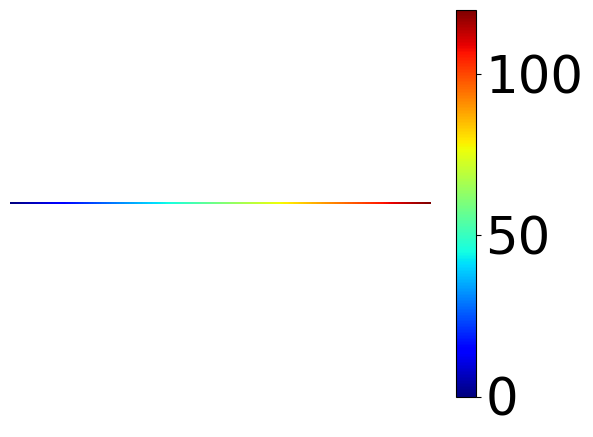

In [7]:
# make a color map with matplotlib.colormaps( BuPu map) for a desired range
import matplotlib as mpl
color_map_name = "jet"
pading_cmap=mpl.colormaps[color_map_name]
# convet the color range to (.8, 1) range
lower, upper = MSE_min, MSE_max
#pading_cmap = mpl.colors.LinearSegmentedColormap.from_list("", [pading_cmap(lower), pading_cmap(upper)])
plt.imshow(np.linspace(lower, upper, 256).reshape(1, -1), cmap=pading_cmap)
# remove the axis
plt.axis("off")

cbar = plt.colorbar()
tick_font_size = 37
cbar.ax.tick_params(labelsize=tick_font_size)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f"color_bar.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)
plt.show()
# increas color bar tiks font size

In [16]:
fig, ax = plt.subplots(grid_size,grid_size, figsize=(10, 10))
c = 0
for i in range(grid_size):
    for j in range(grid_size):
        ax[i,j].axis('off')
        if c < len(clrester_rep_sample_idx):
            ni = int(clrester_rep_sample_idx[c])
            
            imgs_pro = prototypes_list[ni].unsqueeze(0)
            imgs_pro = RF_mask_and_crop(imgs_pro, rf_obj, RF_treshold=2.5)
            norm_score = addhock_normalization(prototypes_score[ni][0], MSE_min, MSE_max)
            imgs_pro = add_padding(imgs_pro[0], padding, pading_cmap(norm_score)[:3])
            # concat tow tensors

            title_str = f"{np.round(prototypes_score[ni][0])}, C{c}"
            ax[i, j].imshow(ToPILImage()(imgs_pro))
            ax[i, j].set_title(title_str, fontsize=20)   
        c += 1
image_path = os.path.join(save_path, "prototipes.pdf")
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.close()  

In [67]:
# make video of inflation and prototypes
from core.utils.CNN_scorers import resize_and_pad_tsr
from core.utils.GAN_utils import upconvGAN
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


gan_name = 'fc6'
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
Ngens = 100
# Define the output video filename
output_filename = 'inflation_clip_e1.mp4'
# Define the frames per second (fps) for the output video
fps = 5
# Define the dimensions of the frames (width, height)
frame_width = 480*2*4
frame_height = 480*4
# Create a VideoWriter object to write the video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec for the output format
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(os.path.join(save_path, output_filename), fourcc, fps, (frame_width, frame_height))

grid_size = 4
os.makedirs(os.path.join(save_path, 'frames'), exist_ok=True)
for gi in np.linspace(0, Ngens-1, 50, dtype=int):
    fig, ax = plt.subplots(grid_size,grid_size, figsize=(20, 10))
    c = 0
    for i in range(grid_size):
        for j in range(grid_size):
            ax[i,j].axis('off')
            if c < len(sample_indacis):
                ni = int(sample_indacis[c])
                imgs_inf = G.visualize_batch_np(unit_inglation_codes[ni])
                imgs_inf = resize_and_pad_tsr(imgs_inf, (147, 147), (40, 40))
                imgs_inf = RF_mask_and_crop(imgs_inf, rf_obj, RF_treshold=2.5)

                imgs_pro = prototypes_list[ni].unsqueeze(0)
                imgs_pro = RF_mask_and_crop(imgs_pro, rf_obj, RF_treshold=2.5)
                # concat tow tensors
                img = torch.cat((imgs_inf[gi], imgs_pro[0]), dim=2)

                title_str = f" {np.round(unit_inflation_score[ni, gi])}  <- act. ->  {np.round(prototypes_score[ni][0])}"
                ax[i, j].imshow(ToPILImage()(img))
                ax[i, j].set_title(title_str, fontsize=20) 
                
               
            c += 1
    plt.tight_layout()
    image_path = os.path.join(save_path, 'frames',f"gen_{gi}_inflation.png")

    plt.savefig(image_path, dpi=300)
    plt.close()
    '''
    canvas = FigureCanvas(fig)
    canvas.draw()  # Render the figure

    # Convert the rendered image to a NumPy array
    width, height = fig.get_size_inches() * fig.get_dpi()
    plt.close(fig)  
    image_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    resized_frame = cv2.resize(image_array, (frame_width, frame_height))
    '''
    
    # Read the image
    frame = cv2.imread(image_path)
    
    # Resize the frame to match the specified dimensions
    frame = cv2.resize(frame, (frame_width, frame_height))

    out.write(frame) 
    
# Release the VideoWriter object
out.release()
cv2.destroyAllWindows()
# Display a message
print("Video creation complete.")



Video creation complete.


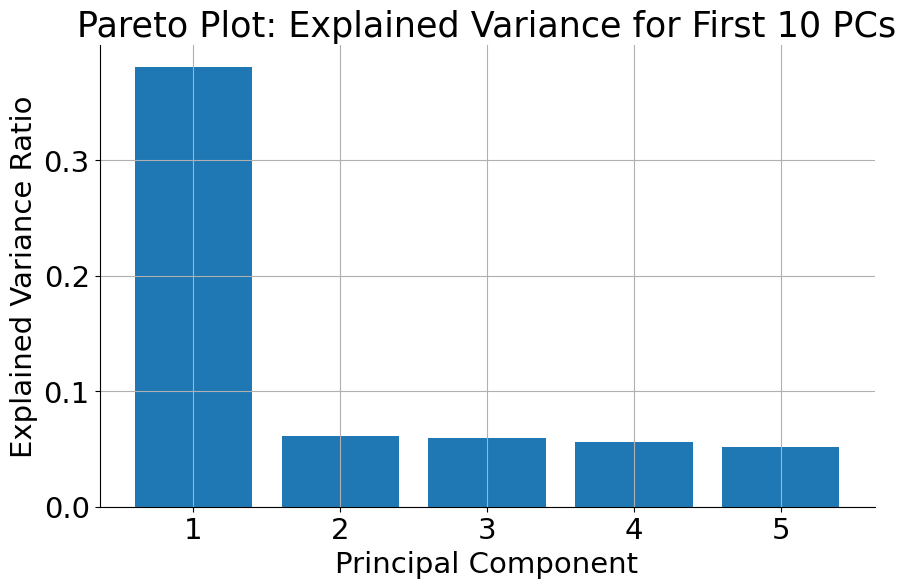

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

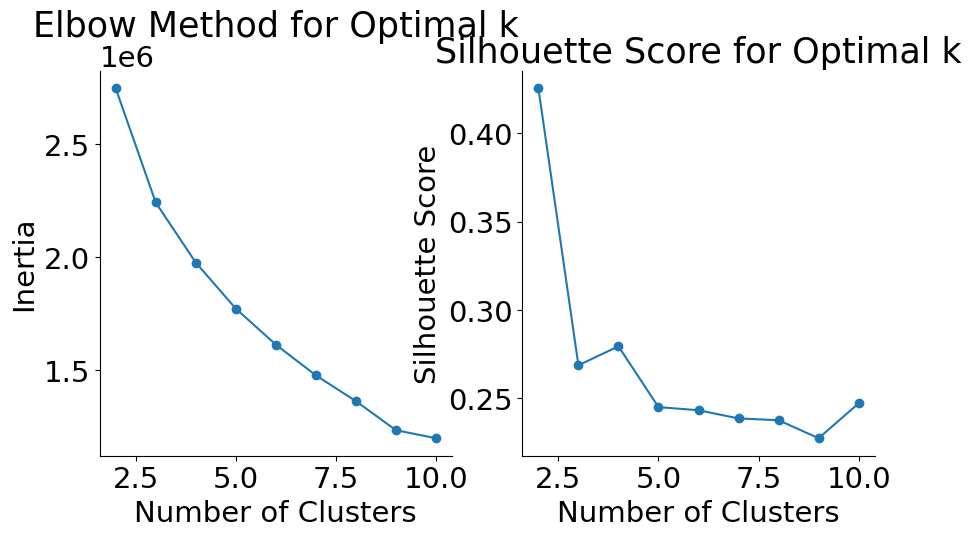

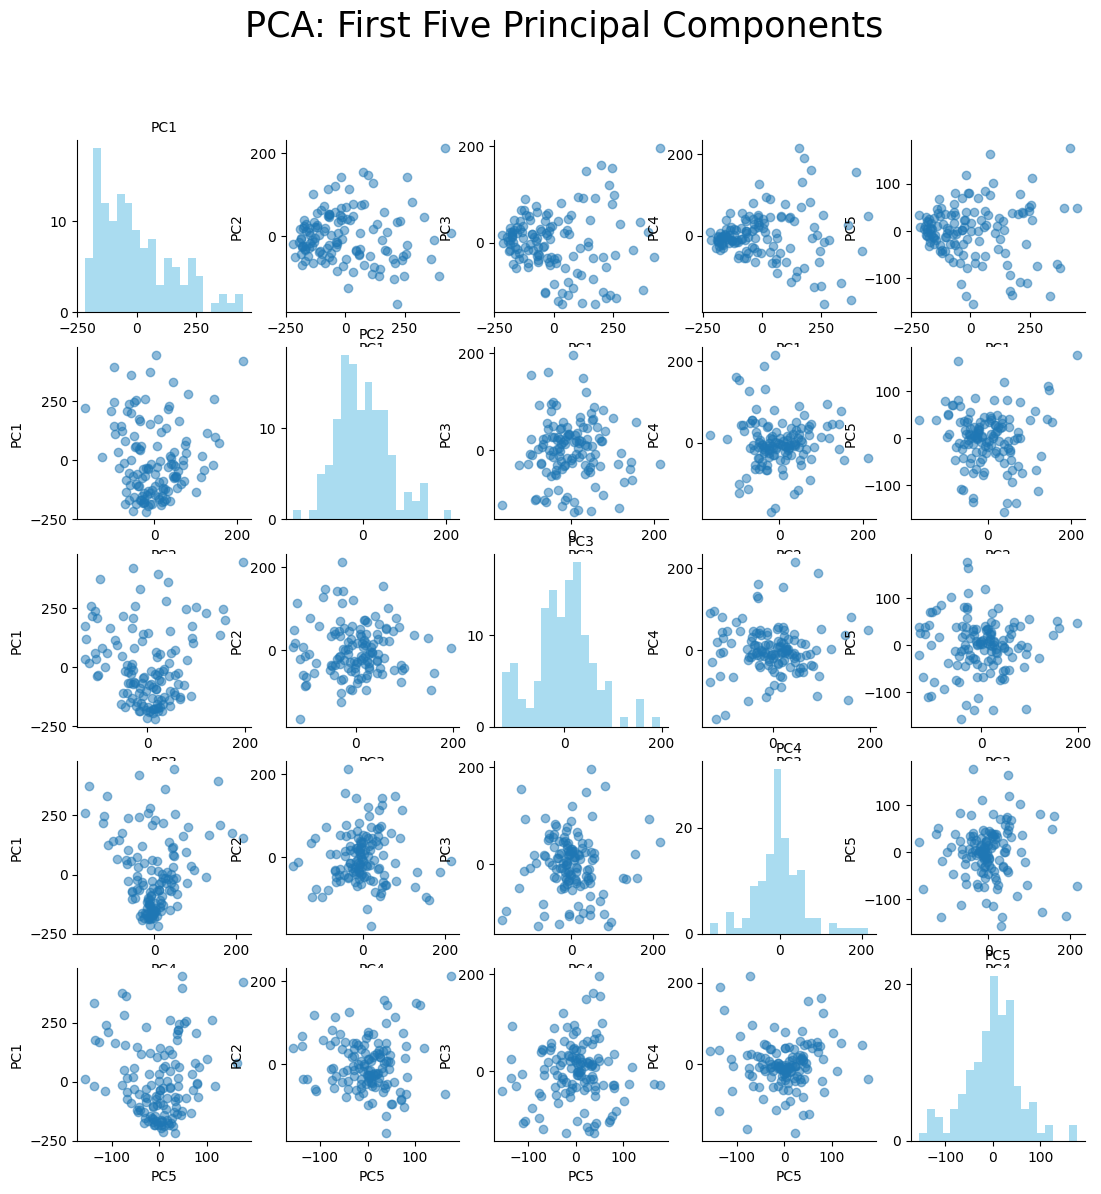

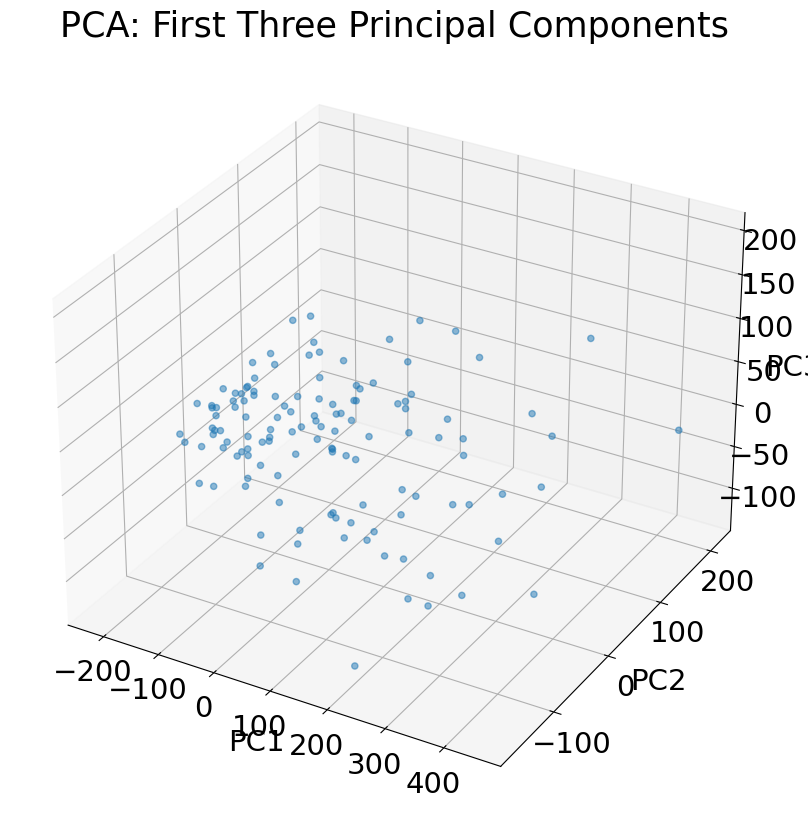

In [88]:
# practice for PCA, MDS clustering and visualization
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Perform PCA
n_components = 5
drobj = PCA(n_components=n_components)  # Choose the number of components
dr_trans = drobj.fit_transform(actmat_mtx)


if drobj.__class__.__name__ == 'PCA':

    #Calculate explained variance ratios
    explained_variance_ratios = drobj.explained_variance_ratio_



    # Pareto plot of explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_components+1), explained_variance_ratios, align='center')
    plt.xticks(range(1, n_components+1))
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Pareto Plot: Explained Variance for First 10 PCs')
    plt.grid()
    plt.show()

# Calculate distortion (inertia) for multiple k values
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)  # Test for k = 2 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dr_trans)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(dr_trans, kmeans.labels_))

# Elbow Method: Plot the inertia values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette Score: Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')


# Visualize the first five principal components
fig, axs = plt.subplots(5, 5, figsize=(13, 13))

for i in range(5):
    for j in range(5):
        if i == j:
            axs[i, j].hist(dr_trans[:, i], bins=20, color='skyblue', alpha=0.7)
            axs[i, j].set_title(f'PC{i+1}')
        else:
            axs[i, j].scatter(dr_trans[:, i], dr_trans[:, j], alpha=0.5)
            axs[i, j].set_xlabel(f'PC{i+1}')
            axs[i, j].set_ylabel(f'PC{j+1}')
        # decrease the font size
        for item in ([axs[i, j].title, axs[i, j].xaxis.label, axs[i, j].yaxis.label] +
                     axs[i, j].get_xticklabels() + axs[i, j].get_yticklabels()):
                    item.set_fontsize(10)

plt.suptitle(f'{drobj.__class__.__name__}: First Five Principal Components')
plt.show()
# do the first three in 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dr_trans[:, 0], dr_trans[:, 1], dr_trans[:, 2], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title(f'{drobj.__class__.__name__}: First Three Principal Components')
plt.show()


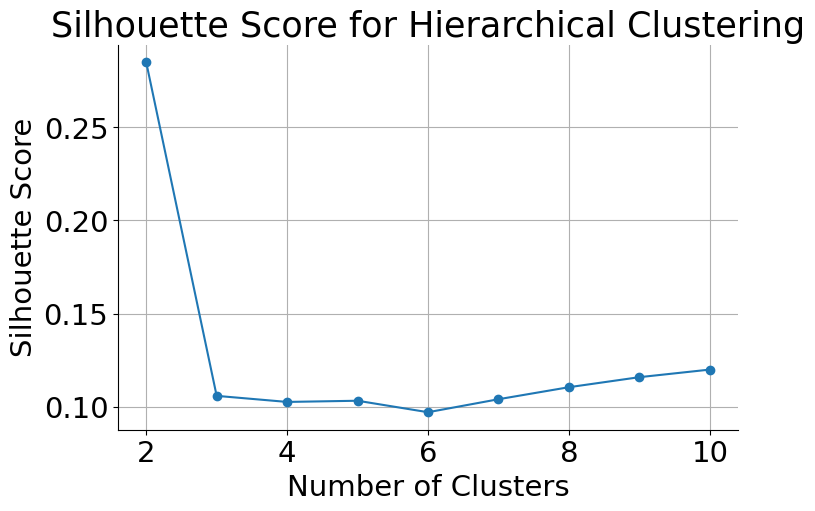

Best Number of Clusters: 2


In [90]:
# get best number of clusters for hierarchical clustering
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load your data matrix into a numpy array
data = actmat_mtx

# Define a range of cluster numbers to try
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store silhouette scores
silhouette_scores = []

# Perform hierarchical clustering and calculate silhouette scores for each cluster number
for num_clusters in cluster_range:
    clusterer = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.grid()
plt.show()

# Find the index of the maximum silhouette score
best_num_clusters = cluster_range[np.argmax(silhouette_scores)]
print("Best Number of Clusters:", best_num_clusters)

In [6]:
# clustering the units based on the similarity of the activity pattern of the units in the last step, and print samples
from core.utils.CNN_scorers import resize_and_pad_tsr
from core.utils.GAN_utils import upconvGAN
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_name_list = metadata_df_cosine["trget_imge_name"].unique()
# perpare the the image_name_list
image_name_list = [image_name_list[1], image_name_list[0], image_name_list[2]]
layer_short= "conv5"
similarity_metric_list = ["MSE", "cosine"]
smpling_types = {"most", 'random'}
pop_size = 128
gen_rerun_id_max = metadata_df_cosine["gen_rerun_id"].max()
pop_resampling_max = metadata_df_cosine["pop_resampling_id"].max()

target_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"

pro_image_type = "best_gen_imgs"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"

inflation_evol_data_type = "generation_data"

# set foint size
plt.rcParams.update({'font.size': 21})

# Load or create your matrix
metric_list = ['euclidean', 'cosine']  # Example metric in ['euclidean', 'correlation', 'cosine']

import numpy as np
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

RF_treshold = 2
pop_resampling_id = 0
num_of_sample_to_print = 16
save_path_root = os.path.join(save_root, f"inflation_profile_{pop_size}_no_line_at_dissimilarity")

# load rsetive filed mask
rf_obj = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))

# setup the  GAN
gan_name = 'fc6'
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
Ngens = 100
num_gen = 100
# Define the frames per second (fps) for the output video
fps = 5
# Define the dimensions of the frames (width, height)
frame_width = 480*2*4
frame_height = 480*4

# Define the output video filename

for smpling_type in smpling_types:   
    save_path_image_root = os.path.join(save_path_root, smpling_type)
    for si, similarity_metric in enumerate(similarity_metric_list):
        metric = metric_list[si]
        save_path_sim_metric = os.path.join(save_path_image_root, similarity_metric)
        for image_name in image_name_list:
            save_path_img_tag = os.path.join(save_path_sim_metric, image_name)
            for gen_rerun_id in range(gen_rerun_id_max+1):
                save_path_gen_rerun = os.path.join(save_path_img_tag, f"gen_rerun_id_{gen_rerun_id}")
                save_path = save_path_gen_rerun
                os.makedirs(save_path, exist_ok=True)
                # Create the VideoWriter object
                # Create a VideoWriter object to write the video

                actmat_mtx = np.zeros((pop_size, pop_size))
                sample_batch_size = 100
                unit_inflation_codes = list()
                unit_inflation_score = np.zeros((pop_size, num_gen))
                prototypes_list = list()
                prototypes_score = np.zeros((pop_size, 1))
                prototypes_unit_id = np.zeros((pop_size, 1))
                for ni in range(pop_size):
                    inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                            output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                            similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                            pop_resampling_id=pop_resampling_id, exp_stage = 'inflation', modif_unit_idx=ni)
                    actmat_all = inflation_evol_data['actmat_all']
                    generations = inflation_evol_data['generations']
                    scores_all = inflation_evol_data['scores_all']
                    best_code_all = inflation_evol_data['best_codes']
                    unit_inflation_codes.append(best_code_all)
                    for gi in range(num_gen):
                        scores_gen = scores_all[generations == gi]
                        max_score_index = scores_gen.argmax()
                        unit_inflation_score[ni, gi] = scores_gen[max_score_index]
                    # get cell prototypes
                    unit_prtoptype = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                    prototypes_score[ni] = column_inquary('score', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                    output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                    similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                    pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                    prototypes_list.append(unit_prtoptype)

                    best_actmat = actmat_all[scores_all.argmax(), :]
                    actmat_mtx[ni, :] = best_actmat

                # Calculate the pairwise distance matrix using correlation distance
                distance_matrix = pairwise_distances(actmat_mtx, metric=metric)
                # Perform hierarchical clustering
                linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')

                # Get the cluster labels using fcluster
                num_clusters = 9  # Number of clusters
                clusters = hierarchy.fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

                # Plot the dendrogram
                plt.figure(figsize=(8, 3))
                dendrogram = hierarchy.dendrogram(linkage_matrix, labels=range(actmat_mtx.shape[0]), color_threshold=0, above_threshold_color='grey')
                plt.title("Dendrogram")
                plt.xlabel("Observations")
                plt.ylabel("Distance")
                plt.xticks([])
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"Dendrogram_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()

                # Get the order of columns after clustering
                sorted_indices = dendrogram['leaves']
                sorted_matrix = actmat_mtx[sorted_indices, :]
                clusters_sorted = clusters[sorted_indices]

                # Calculate the similarity matrix (e.g., correlation) for the sorted columns
                #sorted_similarity_matrix = np.corrcoef(sorted_matrix, rowvar=False)
                sorted_disimilarity_matrix = pairwise_distances(sorted_matrix, metric=metric)
                if metric in ['correlation', 'cosine']:
                    sorted_disimilarity_matrix = 1 - sorted_disimilarity_matrix
                elif metric == 'euclidean':
                    sorted_disimilarity_matrix =  sorted_disimilarity_matrix

                
                # sort the distance_matrix and get sort indacis
                sort_indacis = np.argsort(distance_matrix[distance_matrix.var(axis=0).argmax()])

                # get the 16 samples uniformaly distributed in the range of 0 to len(sort_indacis) and incluuide the first sample
                saples_idx = np.linspace(0, len(sort_indacis)-1, num_of_sample_to_print, dtype=int)
                sample_indacis = sort_indacis[saples_idx]

                # get idx of one random sample for each cluster
                clrester_rep_sample_idx = [np.random.choice(np.where(clusters== i)[0]) for i in np.arange(1, max(clusters))]
                
                # Plot the sorted similarity matrix
                plt.figure(figsize=(8, 8))
                plt.imshow(sorted_disimilarity_matrix, cmap='viridis', interpolation='nearest')
                # Plot colored cluster lines on the similarity matrix
                cbar = plt.colorbar()
                cbar.set_label(f'{metric}',  labelpad=15, fontweight='bold', fontsize=27)   
                plt.title("Sorted disimilarity matrix")
                plt.xlabel("Sorted Observations")
                plt.ylabel("Sorted Observations")
                plt.tight_layout()
                # save the figure
                plt.savefig(os.path.join(save_path, f"disimilarity_matrix_{image_name}_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
                plt.close()
                ## plot reconstruction results


C:\Users\Alireza\AppData\Local\Temp\ipykernel_15336\324911749.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
C:\Users\Alireza\AppData\Local\Temp\ipykernel_15336\324911749.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
C:\Users\Alireza\AppData\Local\Temp\ipykernel_15336\324911749.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance_matrix, method='complete')
C:\Users\Alireza\AppData\Local\Temp\ipykernel_15336\324911749.py:111: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix 